In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from __future__ import division

A more complete description of the data, including the source, can be found in the git README.md file.

Labs and vitals categories were previously discretized from their raw values using knn into 5 clusters; no code book was available for interpretation,so removed from model.

AbxUTI was removed as it is correlated to all cases doctor diagnosed as UTI.

Dummy variables were created for all string categorical features.

All features with > 20% not_recorded values were dropped.

drop PATID, ID (in the future, retain PATID to be able to compare predictions from test set back to doctor assessment).

drop ua_bacteria as it is correlated with diagnosis and not useful for clinical prediction

recode from Yes/No to 1/0: in this order so true_dx is the last column for y_pred

prior_history outpat_meds abxUTI to abxUTI (yes/no) UTI_diag to dr_dx UCX_abnormal to true_dx

outcome variable and comparison outcome variable (doctor diagnosis)

data["dr_dx"] = pd.Series(np.where(data["UTI_diag"].values == "Yes", 1,0),data.index) data["true_dx"] = pd.Series(np.where(data["UCX_abnormal"].values == "yes", 1,0),data.index)

recoded everything to numeric: for pH, had to replace NaN values with imputed mean (ran test to be sure mean didn't differ between outcome types)

Balanced data set to achieve 50% true_dx 0 and 1.  This reduced the data set from 80,000 observations to 40,000.

Saved the cleaned data for the model: mod2.to_csv("uti_recoded_model2.tsv", sep='\t')

I looked at the correlations here: mod2_corr = mod2.corr() resamp_corr = resamp.corr() then made a list of those with corr > 70%

indices = np.where(mod2_corr > 0.7) indices = [(mod2_corr.index[x], mod2_corr.columns[y]) for x, y in zip(*indices) if x != y and x < y]

resamp_indices = np.where(resamp_corr > 0.7) resamp_indices = [(resamp_corr.index[x], resamp_corr.columns[y]) for x, y in zip(*resamp_indices) if x != y and x < y] resamp_indices

A separate notebook was created to explore and annotate building a model based on extracting only female observations from the data set.  This data set was not balanced. (A separate notebook was run for a female-only, balanced data set, but the observations were only 14K each outcome).  Women get UTI much more frequently than men, so it is of interest to know whether the predictors or feature importance changes if we consider only women.  According to that set of operations, the features are very similar but the strength of some of the predictors is different.  This can be compared in the slide deck at:
bit.ly/Sheila_Adams-Sapper_demo

Next steps:  Try to weight the classes rather than dropping observations to balance the data set.

In [2]:
mod2 = pd.read_csv('uti_recoded_model2.tsv', sep = '\t')
mod2 = mod2.iloc[:,1:]

After the first pass of cleaning/pre-processing the data I noticed a problem with specific gravity values that occurred below and above physiolog. normal:

In [65]:
mod2['ua_spec_grav'].value_counts()

1.020    3571
1.018    3564
1.015    3541
1.019    3512
1.016    3484
1.017    3465
1.014    3374
1.013    3296
1.021    3233
1.012    3109
1.022    3030
1.011    3019
1.023    2967
1.024    2944
1.010    2921
1.025    2853
1.026    2459
1.009    2452
1.008    2233
1.027    2157
1.030    2156
1.028    2045
1.007    1885
1.029    1676
1.006    1535
1.005    1466
1.031    1378
1.034     883
1.033     815
1.004     730
         ... 
1.088       4
1.069       4
1.075       3
1.108       3
1.083       2
1.094       2
1.081       2
1.099       2
1.079       2
1.102       2
1.091       2
1.063       2
1.073       2
1.135       1
1.106       1
1.305       1
1.089       1
0.018       1
1.148       1
5.500       1
1.120       1
1.105       1
1.128       1
1.104       1
0.200       1
1.071       1
1.093       1
1.085       1
1.097       1
1.096       1
Name: ua_spec_grav, Length: 109, dtype: int64

find the rows where specific gravity is below physiol. norms between 1 - 1.030, allow for abnormal test results due to dehydration and kidney dysfunction:

In [81]:
sg_low = mod2[mod2['ua_spec_grav']< 1]
sg_high = mod2[mod2['ua_spec_grav']> 1.5]

In [70]:
sg_high

,ua_ph,ua_spec_grav,age,abx,Abdominal_hernia,Abdominal_pain,Acute_and_unspecified_renal_failure,Anal_and_rectal_conditions,Calculus_of_urinary_tract,Cancer,...,arrival_Other,arrival_Police,arrival_Public Transportation,arrival_Sky Health,arrival_Taxi,arrival_Walk-in,arrival_Wheelchair,arrival_not_reported,dr_dx,true_dx
40254,6.0,5.5,53,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [77]:
sg_low

,ua_ph,ua_spec_grav,age,abx,Abdominal_hernia,Abdominal_pain,Acute_and_unspecified_renal_failure,Anal_and_rectal_conditions,Calculus_of_urinary_tract,Cancer,...,arrival_Other,arrival_Police,arrival_Public Transportation,arrival_Sky Health,arrival_Taxi,arrival_Walk-in,arrival_Wheelchair,arrival_not_reported,dr_dx,true_dx
40724,6.5,0.200,40,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
50161,6.0,0.018,75,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


re-code as boolean to be able to drop the extreme data observations from the data set

In [ ]:
sg_low = mod2['ua_spec_grav']< 1
sg_high = mod2['ua_spec_grav']> 1.5

drop rows where specific gravity is below/above physiol. norms between 1 - 1.030

In [84]:
mod2.drop(mod2[sg_low].index, axis=0,inplace=True)
mod2.drop(mod2[sg_high].index, axis=0,inplace=True)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


In [85]:
mod2.shape

(80384, 245)

Balance the data by subsampling from the more frequent no UTI (0) outcome category

In [86]:
resamp = mod2.drop(mod2[mod2['true_dx'] == 0].sample(frac=0.70).index)
resamp.shape

(36914, 245)

Scale the continuous variables

In [87]:
age =(resamp["age"]- resamp["age"].min())/(resamp["age"].max() - resamp["age"].min())
resamp["age"] = age

ph =(resamp["ua_ph"]- resamp["ua_ph"].min())/(resamp["ua_ph"].max() - resamp["ua_ph"].min())
resamp["ua_ph"] = ph

spec_grav =(resamp["ua_spec_grav"]- resamp["ua_spec_grav"].min())/(resamp["ua_spec_grav"].max() - resamp["ua_spec_grav"].min())
resamp["ua_spec_grav"] = spec_grav

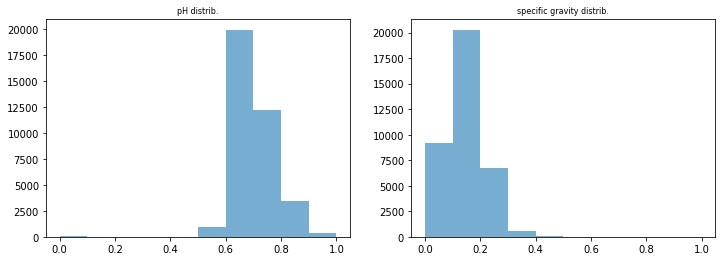

In [88]:
fig, axes = plt.subplots(ncols=2, figsize=(12, 4))
axes[0].hist('ua_ph', data=resamp,label='pH', bins=10, alpha=0.6)
axes[0].set_title('pH distrib.', fontsize=8)
axes[1].hist('ua_spec_grav', data=resamp,label='specific gravity', bins=10, alpha=0.6)
axes[1].set_title('specific gravity distrib.', fontsize=8)
plt.show()

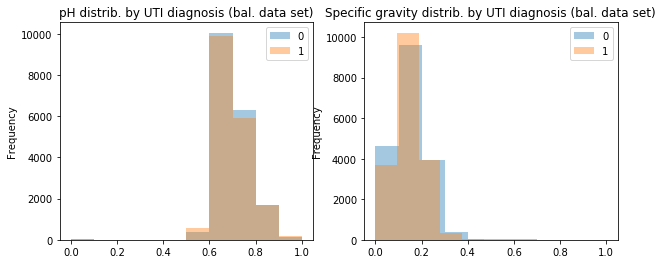

In [89]:
pH_byDx = resamp.groupby("true_dx")["ua_ph"]
sg_byDx = resamp.groupby("true_dx")["ua_spec_grav"]
# fig, axes = plt.subplots(2,1,1, figsize=(12, 4))
plt.subplot(1, 2, 1)
pH_byDx.plot(kind='hist', figsize=[10,4], alpha=.4, legend=True, title = "pH distrib. by UTI diagnosis (bal. data set)")
plt.subplot(1, 2, 2)
sg_byDx.plot(kind='hist', figsize=[10,4], alpha=.4, legend=True, title = "Specific gravity distrib. by UTI diagnosis (bal. data set)")
plt.show()

Look at the doctors' assessment performance and look at the differences in means by outcome

In [5]:
drdx_v_true = pd.crosstab(resamp["true_dx"], resamp["dr_dx"])
drdx_v_true

dr_dx,0,1
true_dx,,
0,15742,2889
1,10716,7568


In [90]:
resamp.groupby('true_dx').mean()

,ua_ph,ua_spec_grav,age,abx,Abdominal_hernia,Abdominal_pain,Acute_and_unspecified_renal_failure,Anal_and_rectal_conditions,Calculus_of_urinary_tract,Cancer,...,arrival_Medical Flight,arrival_Other,arrival_Police,arrival_Public Transportation,arrival_Sky Health,arrival_Taxi,arrival_Walk-in,arrival_Wheelchair,arrival_not_reported,dr_dx
true_dx,,,,,,,,,,,,,,,,,,,,,
0,0.701258,0.151326,0.381376,0.493076,0.031830,0.014010,0.009984,0.004187,0.061084,0.083306,...,0.0,0.010789,0.000054,0.003757,0.0,0.001664,0.146055,0.003435,0.015083,0.155233
1,0.697963,0.142829,0.435192,0.782816,0.029534,0.013126,0.015423,0.004594,0.070882,0.108237,...,0.0,0.008259,0.000055,0.002735,0.0,0.003500,0.100689,0.003993,0.011540,0.413914


Look at the age distribution after balancing the data set

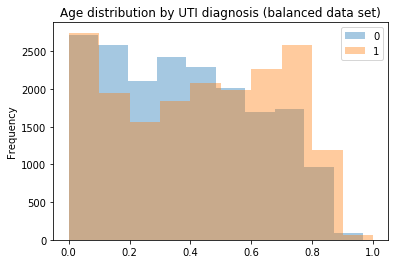

In [49]:
age_byDx = resamp.groupby("true_dx")["age"]
age_byDx.plot(kind='hist', figsize=[6,4], alpha=.4, legend=True, title = "Age distribution by UTI diagnosis (balanced data set)") # alpha for transparency
plt.savefig('age_distrib_bal.pdf')

True diagnosis by gender:

In [101]:
print((resamp['gender_Female'].sum()/len(resamp)),(resamp['gender_Male'].sum()/len(resamp)))

(0.7187246031316031, 0.2691390800238392)


In [96]:
female_v_true = pd.crosstab(resamp["true_dx"], resamp["gender_Female"])
female_v_true

gender_Female,0,1
true_dx,,
0,6434,12196
1,3949,14335


In [97]:
male_v_true = pd.crosstab(resamp["true_dx"], resamp["gender_Male"])
male_v_true

gender_Male,0,1
true_dx,,
0,12450,6180
1,14529,3755


Make the first split for training and the hold-out test set

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics

X = resamp.iloc[:, 0:243].values
y = resamp.iloc[:, 244].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 11)

C:\ProgramData\Anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


For Recursive Feature Elimination, look at the grid curve for accuracy tradeoff for a smaller set of features
set the C regularization parameter very high so it does not apply weighting for RFE (The sklearn LogisticRegression has an L2 penalty default that cannot be turned off - unless one wants to select L1)

Optimal number of features : 94


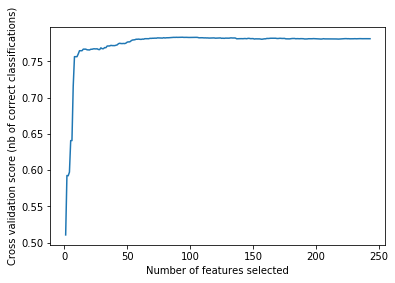

In [52]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV


# Use X_train created above from 80/20 split of resamp data set

# Create the RFE object and compute a cross-validated score.
logistic = linear_model.LogisticRegression(C=10**6)
# The "accuracy" scoring is proportional to the number of correct
# classifications
rfecv = RFECV(estimator=logistic, step=1, cv=StratifiedKFold(3),
              scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.savefig('RFECV_grid_largeC.png')
plt.show()

In [53]:
rfecv.grid_scores_[0:30]

array([ 0.51053035,  0.5924498 ,  0.59207729,  0.59712318,  0.64060144,
        0.64060144,  0.71549563,  0.75633269,  0.75629884,  0.75629884,
        0.76009095,  0.76452702,  0.76456088,  0.76452703,  0.76669395,
        0.76669395,  0.76669395,  0.76581347,  0.76564414,  0.76557642,
        0.76655831,  0.76655831,  0.76710004,  0.76716777,  0.76699847,
        0.76720162,  0.76625356,  0.76605041,  0.76848868,  0.7673035 ])

Make a second split in the training set to allow for a separate validation set prior to final testing on the hold-out test set.

In [8]:
from sklearn.cross_validation import train_test_split
X_train_rfe, X_val_rfe, y_train_rfe, y_val_rfe = train_test_split(X_train, y_train, test_size = 0.20, random_state = 1)

RFE originally run with 30 features, but had a very high number of 'not_reported' variables. The final test was run with 16, which is the transition point in the GridSearch curve beyond which not much additional accuracy is obtained.

In [48]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=10**6)

rfe = RFE(logreg,16)
rfe = rfe.fit(X_train_rfe, y_train_rfe)
print(rfe.support_)
print(rfe.ranking_)

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
  True False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False  True  True False
 False False False False False False  True False False False False False
 False False  True False False False False False False False False False
 False  True False False False False False False False False  True  True
 False False  True False False False False False False  True  True False
 False  True False False False False False False False False False False
 False False False False False False False False Fa

In [50]:
rfe.score(X_train_rfe, y_train_rfe)

0.76651851851851849

In [51]:
cols = []
for i,val in enumerate(rfe.support_):
    if val == True:
        cols.append(resamp.columns[i])
cols

['ANTIALLERGY',
 'ua_bili_large',
 'ua_bili_moderate',
 'ua_blood_not_reported',
 'ua_color_not_reported',
 'ua_ketones_4+',
 'ua_leuk_negative',
 'ua_leuk_not_reported',
 'ua_nitrite_negative',
 'ua_protein_not_reported',
 'ua_protein_other',
 'ua_urobili_not_reported',
 'race_Native Hawaiian or Other Pacific Islander',
 'disposition_LWBS before Triage',
 'arrival_Assist From Vehicle',
 'arrival_Sky Health']

Make the training set into a dataframe to be able to pass the new column names to the orig X_train matrix

In [9]:
train_cols = resamp.columns[0:(len(resamp.columns)-2)] #to remove dr_dx, true_dx, the last 2 columns in resamp
X_train_rfe_df = pd.DataFrame(X_train_rfe)
X_train_rfe_df.columns = train_cols
X_train_rfe_df.head()

,ua_ph,ua_spec_grav,age,abx,Abdominal_hernia,Abdominal_pain,Acute_and_unspecified_renal_failure,Anal_and_rectal_conditions,Calculus_of_urinary_tract,Cancer,...,arrival_Larchmont VAC,arrival_Medical Flight,arrival_Other,arrival_Police,arrival_Public Transportation,arrival_Sky Health,arrival_Taxi,arrival_Walk-in,arrival_Wheelchair,arrival_not_reported
0,0.666667,0.878692,0.340659,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.611111,0.856540,0.648352,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.611111,0.882911,0.373626,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.611111,0.875527,0.087912,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.666667,0.857595,0.065934,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Proceed to Logistic Regression with L1 regularization penalty to compare feature output

Perform GridSearch for optimum alpha.  Ideal was given as 0.001, but exploration done with 0.01, 0.005, and 0.001 showed that 0.005 was preferable in terms of trade-off between feature relevance and model accuracy.

(0.001, 0.31622776601683794)

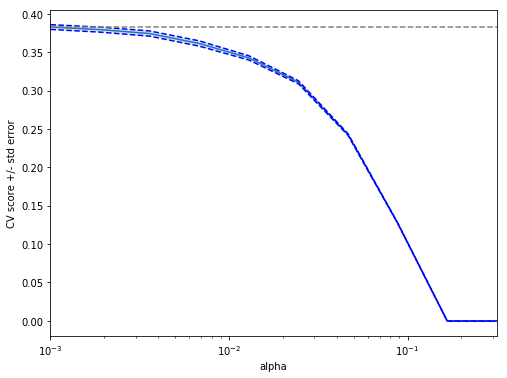

In [45]:
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


lasso = Lasso(random_state=0, max_iter=1e5)
alphas = np.logspace(-3, -0.5, 10)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False, return_train_score=True)
clf.fit(X_train, y_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

In [19]:
from sklearn import linear_model

logl1_005 = LogisticRegression(random_state=123, penalty='l1', solver='liblinear', C=0.005)
logl1_005.fit(X_train_rfe,y_train_rfe)

print(logl1_005.coef_)
print(logl1_005.intercept_)

[[ 0.          0.          0.          0.40104411  0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0

Notebook output differs slight when re-run:  vitamins and ua_protein_negative were not previously in the list except with regularization parameter higher than 0.005.  Will remove for consistency of past reports.

In [20]:
logl1_005_coef = np.nonzero(logl1_005.coef_)[1]
for i in logl1_005_coef:
    print(resamp.columns[i])

abx
VITAMINS
ua_bili_negative
ua_blood_negative
ua_clarity_clear
ua_leuk_large
ua_leuk_negative
ua_nitrite_negative
ua_nitrite_positive
ua_protein_negative
ua_urobili_negative
gender_Female
gender_Male
employStatus_Retired
insurance_status_Medicare


In [12]:
l1_cols = ['abx','ua_bili_negative','ua_blood_negative','ua_clarity_clear','ua_leuk_large','ua_leuk_negative',
           'ua_nitrite_negative','ua_nitrite_positive','ua_urobili_negative','gender_Female','gender_Male',
           'employStatus_Retired','insurance_status_Medicare']

In [13]:
X_l1 = X_train_rfe_df[l1_cols] # new X with reduced features
y_l1 = y_train_rfe.ravel()

compare coeficients to logistic model without regularization parameters built in

In [14]:
import statsmodels.api as sm
logit_model=sm.Logit(y_l1,X_l1.astype(float))
result=logit_model.fit()
print(result.summary())

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.477880
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                23625
Model:                          Logit   Df Residuals:                    23612
Method:                           MLE   Df Model:                           12
Date:                Sun, 01 Jul 2018   Pseudo R-squ.:                  0.3105
Time:                        21:42:24   Log-Likelihood:                -11290.
converged:                       True   LL-Null:                       -16375.
                                        LLR p-value:                     0.000
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
abx                           0.5015      0.036     14.000      0.000       0.

In [21]:
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression(random_state=123, penalty='l1', solver='liblinear', C=0.005)
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_l1, y_l1, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.768


Prepare the validation set for model testing

In [22]:
train_cols = resamp.columns[0:(len(resamp.columns)-2)]
X_val_rfe_df = pd.DataFrame(X_val_rfe)
X_val_rfe_df.columns = train_cols

y_val_test = y_val_rfe.ravel()
X_val_test_l1 = X_val_rfe_df[l1_cols]
X_val_test_l1.shape

(5907, 13)

In [25]:
y_l1_train = pd.DataFrame(y_l1)

Fit the model with the smaller feature set and get the prediction from the validation set.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
logreg_l1 = LogisticRegression(random_state=123, penalty='l1', solver='liblinear', C=0.005)
logreg_l1.fit(X_l1, y_l1)
print(logreg_l1.intercept_, logreg_l1.coef_)

(array([ 0.]), array([[ 0.4037955 ,  0.05368838, -0.21863883, -0.58107536,  0.49028412,
        -1.37994119, -0.04859236,  1.22174261,  0.1744266 ,  0.29376122,
        -0.09368166,  0.12589878,  0.04585101]]))


In [29]:
y_pred_l1 = logreg_l1.predict(X_val_test_l1)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_l1.score(X_val_test_l1, y_val_test)))

Accuracy of logistic regression classifier on test set: 0.77


In [30]:
from sklearn.metrics import confusion_matrix
cm_l1_final = confusion_matrix(y_val_test, y_pred_l1)
print(cm_l1_final)

[[2205  778]
 [ 557 2367]]


In [31]:
cm_l1_val_set = cm_l1_final.astype('float') / cm_l1_final.sum(axis=1)[:, np.newaxis]
cm_l1_val_set

array([[ 0.73918874,  0.26081126],
       [ 0.19049248,  0.80950752]])

In [32]:
from sklearn.metrics import classification_report
print(classification_report(y_val_test, y_pred_l1))

             precision    recall  f1-score   support

          0       0.80      0.74      0.77      2983
          1       0.75      0.81      0.78      2924

avg / total       0.78      0.77      0.77      5907



Test the model against the hold-out test set. First prepare the test set as df.

In [33]:
train_cols = resamp.columns[0:(len(resamp.columns)-2)] #to eliminate true_dx
X_final_test_df = pd.DataFrame(X_test)
X_final_test_df.columns = train_cols
X_final_test_df.head()

,ua_ph,ua_spec_grav,age,abx,Abdominal_hernia,Abdominal_pain,Acute_and_unspecified_renal_failure,Anal_and_rectal_conditions,Calculus_of_urinary_tract,Cancer,...,arrival_Larchmont VAC,arrival_Medical Flight,arrival_Other,arrival_Police,arrival_Public Transportation,arrival_Sky Health,arrival_Taxi,arrival_Walk-in,arrival_Wheelchair,arrival_not_reported
0,0.666667,0.854430,0.538462,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.722222,0.872363,0.373626,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.666667,0.850211,0.461538,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.722222,0.858650,0.648352,1.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.666667,0.850211,0.450549,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [34]:
y_final_test = y_test
X_final_test = X_final_test_df[l1_cols]
X_final_test.shape

(7383, 13)

This file was saved to pickle for the online tool.
X_final_test.to_csv('x_test_l1_final.tsv', sep = '\t')

In [37]:
y_pred_l1_final = logreg_l1.predict(X_final_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg_l1.score(X_final_test, y_final_test)))

Accuracy of logistic regression classifier on test set: 0.76


In [38]:
from sklearn.metrics import confusion_matrix
confusion_matrix_l1 = confusion_matrix(y_final_test, y_pred_l1_final)
print(confusion_matrix_l1)

[[2728 1001]
 [ 744 2910]]


In [39]:
cm_l1_transform = confusion_matrix_l1.astype('float') / confusion_matrix_l1.sum(axis=1)[:, np.newaxis]
cm_l1_transform

array([[ 0.73156342,  0.26843658],
       [ 0.20361248,  0.79638752]])

In [41]:
from sklearn.metrics import classification_report
print(classification_report(y_final_test, y_pred_l1_final))

             precision    recall  f1-score   support

          0       0.79      0.73      0.76      3729
          1       0.74      0.80      0.77      3654

avg / total       0.77      0.76      0.76      7383



Plot the features by importance

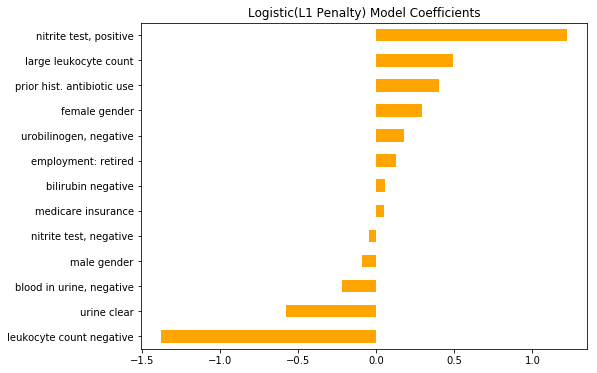

In [42]:
from pandas import Series, DataFrame

comm_names = ['prior hist. antibiotic use', 'bilirubin negative', 'blood in urine, negative', 'urine clear', 
              'large leukocyte count','leukocyte count negative', 'nitrite test, negative', 'nitrite test, positive',
              'urobilinogen, negative', 'female gender','male gender','employment: retired','medicare insurance']
plt.figure(figsize=(8,6))
plt.tight_layout()
predictors_final = comm_names
predictors_final = Series(logreg_l1.coef_[0,:],predictors_final).sort_values()
predictors_final.plot(kind='barh', title= 'Logistic(L1 Penalty) Model Coefficients', color='orange')
plt.savefig('l1_model_coef_balanced.png')

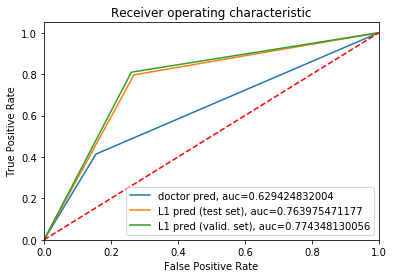

In [43]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()

#doctor pred
pred = resamp.iloc[:,243]
true = resamp.iloc[:,244]
fpr, tpr, thresh = metrics.roc_curve(true, pred)
auc = metrics.roc_auc_score(true, pred)
plt.plot(fpr,tpr,label="doctor pred, auc="+str(auc))

#L1 hold-out test set y_pred
pred = y_pred_l1_final
true = y_test
fpr, tpr, thresh = metrics.roc_curve(true, pred)
auc = metrics.roc_auc_score(true, pred)
plt.plot(fpr,tpr,label="L1 pred (test set), auc="+str(auc))

#L1, validation set y_pred
pred = y_pred_l1
true = y_val_test
fpr, tpr, thresh = metrics.roc_curve(true, pred)
auc = metrics.roc_auc_score(true, pred)
plt.plot(fpr,tpr,label="L1 pred (valid. set), auc="+str(auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.legend(loc=0)
plt.savefig('ROC_dr_v_models')
plt.show()

This is the model used to run the Yoot Assess online assessment tool at www.yootassess.online